In [477]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso, LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,f1_score,precision_score,recall_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler,LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB,GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
import xgboost as xgb
from xgboost import XGBClassifier
import re
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer


In [479]:
df = pd.read_csv("watches.csv")

In [481]:
df.head()

,title,brand,price,rating,reviews
0,Fire-Boltt Ninja Call Pro Plus Smart Watch 1.8...,NaN,₹999,3.9,96054.0
1,Fire-Boltt Phoenix Smart Watch with Bluetooth ...,NaN,"₹1,099",3.9,82577.0
2,Noise Twist Round dial Smart Watch with Blueto...,NaN,"₹1,099",4.0,15003.0
3,Fire-Boltt Ninja Call Pro Plus Smart Watch 1.8...,NaN,₹999,3.9,96054.0
4,"Noise Pulse 2 Max 1.85"" Display, Bluetooth Cal...",NaN,"₹1,099",4.0,17941.0


In [483]:
df.tail()

,title,brand,price,rating,reviews
1195,Boult Newly Launched Crown R Pro Smart Watch 1...,Boult,"₹1,799",4.5,120.0
1196,Analog Digital 3ATM Waterproof Sports Watch fo...,V2A,₹990,4.0,880.0
1197,Chronograph Ultra-Thin Unisex Multi Function D...,V2A,₹599,3.9,1840.0
1198,Analogue - Digital Men's Watch (Green Dial Gre...,V2A,"₹1,090",4.1,614.0
1199,S-Shock Military Green Analog Digital Fashion ...,V2A,"₹1,090",4.2,263.0


In [485]:
df = df.drop_duplicates()

In [487]:
df.shape

(876, 5)

In [489]:
df.isnull().sum()

title        0
brand      277
price        0
rating      26
reviews     26
dtype: int64

In [491]:
df.dropna(subset=["brand", "rating", "reviews"], how='all',inplace=True)

In [493]:
df.shape

(864, 5)

In [495]:
df.isnull().sum()

title        0
brand      265
price        0
rating      14
reviews     14
dtype: int64

In [497]:
df.drop(columns=['brand'], inplace=True)

In [499]:
df["title"] = df["title"].str.replace(
    r"\b(analog|analogue|digital|smart|smartwatch)\b", "", 
    case=False, regex=True
).str.strip()

In [501]:
df.head()

,title,price,rating,reviews
0,Fire-Boltt Ninja Call Pro Plus Watch 1.83 inc...,₹999,3.9,96054.0
1,Fire-Boltt Phoenix Watch with Bluetooth Calli...,"₹1,099",3.9,82577.0
2,Noise Twist Round dial Watch with Bluetooth C...,"₹1,099",4.0,15003.0
4,"Noise Pulse 2 Max 1.85"" Display, Bluetooth Cal...","₹1,099",4.0,17941.0
5,"boAt Lunar Discovery w/ 1.39"" (3.5 cm) HD Disp...","₹1,199",3.9,23131.0


In [503]:
df["rating"] = df["rating"].fillna(df["rating"].median())
df["reviews"] = df["reviews"].fillna(df["reviews"].median())

In [505]:
df.isnull().sum()

title      0
price      0
rating     0
reviews    0
dtype: int64

In [507]:
df['price'] = df['price'].str.replace('₹', '', regex=False)
df['price'] = df['price'].str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'])

In [509]:
df.head()

,title,price,rating,reviews
0,Fire-Boltt Ninja Call Pro Plus Watch 1.83 inc...,999.0,3.9,96054.0
1,Fire-Boltt Phoenix Watch with Bluetooth Calli...,1099.0,3.9,82577.0
2,Noise Twist Round dial Watch with Bluetooth C...,1099.0,4.0,15003.0
4,"Noise Pulse 2 Max 1.85"" Display, Bluetooth Cal...",1099.0,4.0,17941.0
5,"boAt Lunar Discovery w/ 1.39"" (3.5 cm) HD Disp...",1199.0,3.9,23131.0


# EDA

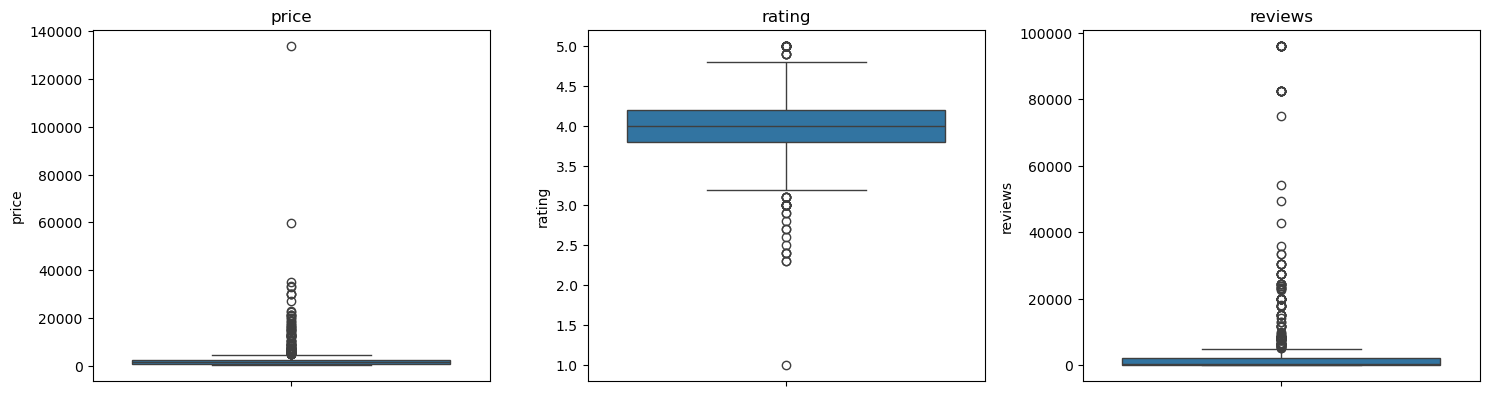

In [512]:
numeric_columns = df.select_dtypes(include='number') # Select only numerical columns

plt.figure(figsize=(15, 30))
for i in range(len(numeric_columns.columns)):
    plt.subplot(8, 3, i + 1)
    sns.boxplot(y=numeric_columns.columns[i], data=df)
    plt.title(numeric_columns.columns[i])
    plt.tight_layout()

plt.show()

In [513]:
df = df[df['rating'] >= 2]

df = df[df['price'] <= 55000]

In [514]:
df.shape

(861, 4)

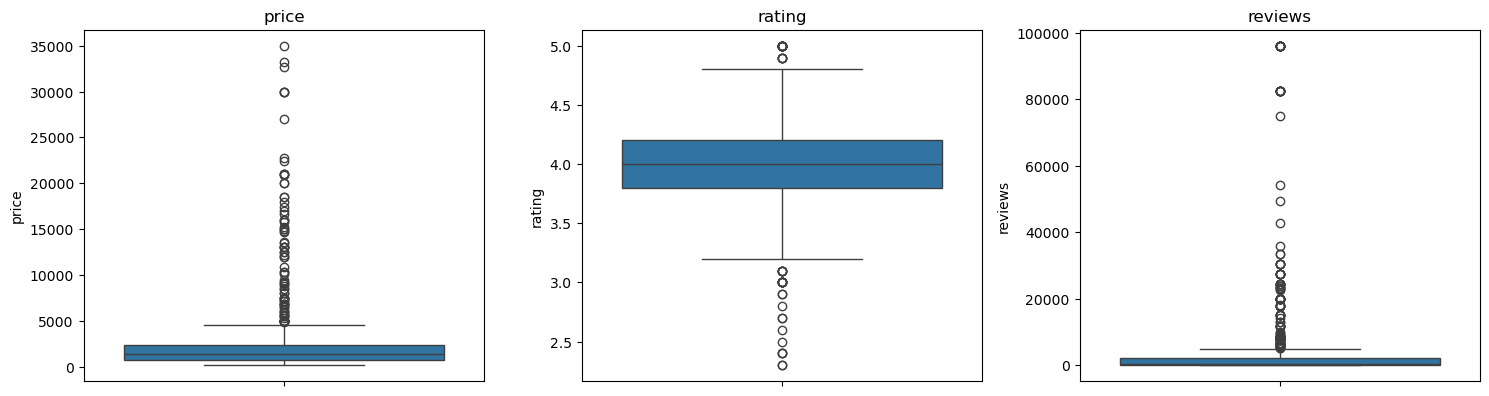

In [515]:
numeric_columns = df.select_dtypes(include='number') 

plt.figure(figsize=(15, 30))
for i in range(len(numeric_columns.columns)):
    plt.subplot(8, 3, i + 1)
    sns.boxplot(y=numeric_columns.columns[i], data=df)
    plt.title(numeric_columns.columns[i])
    plt.tight_layout()

plt.show()

## Push To SQL

# NLP

In [522]:
def clean_title(text):
    text = text.lower()
    text = re.sub(r'[\"\,\/\|\%\+\-\(\)\*]', '', text)
    return text
df['title']=df['title'].apply(clean_title)

In [523]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yahav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\yahav\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yahav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yahav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yahav\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [526]:
text = ' '.join(df['title'])
tokens = word_tokenize(text.lower())
tokens = [word for word in tokens if word.isalpha()]  # remove punctuation
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word not in stop_words]

# POS tagging
pos_tags = pos_tag(tokens)
common_nouns = [word for word, tag in pos_tags if tag in ('NN', 'NNS')]

noun_freq = Counter(common_nouns)
print(noun_freq.most_common(50))

[('watch', 643), ('men', 408), ('sports', 262), ('strap', 214), ('display', 184), ('modes', 127), ('steel', 116), ('women', 100), ('bt', 85), ('voice', 83), ('stainless', 83), ('kids', 79), ('watches', 76), ('metal', 68), ('silicone', 66), ('rate', 65), ('monitoring', 65), ('assistant', 65), ('heart', 62), ('band', 62), ('girls', 58), ('noise', 57), ('dial', 56), ('wrist', 56), ('battery', 53), ('date', 51), ('health', 50), ('hd', 48), ('day', 48), ('days', 47), ('quartz', 44), ('silver', 43), ('crown', 38), ('nits', 37), ('bluetooth', 35), ('alarm', 35), ('leather', 34), ('mode', 33), ('boys', 32), ('brightness', 31), ('water', 31), ('fastrack', 30), ('premium', 30), ('chain', 30), ('stopwatch', 30), ('boat', 29), ('grey', 29), ('fireboltt', 28), ('inch', 28), ('monitor', 28)]


In [528]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [529]:
def stop_remove(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)
df['title'] = df['title'].apply(stop_remove)

In [530]:
df.head()

,title,price,rating,reviews
0,fireboltt ninja call pro plus watch inch bluet...,999.0,3.9,96054.0
1,fireboltt phoenix watch bluetooth calling spor...,1099.0,3.9,82577.0
2,noise twist round dial watch bluetooth calling...,1099.0,4.0,15003.0
4,noise pulse max display bluetooth calling watc...,1099.0,4.0,17941.0
5,boat lunar discovery w cm hd display turnbytur...,1199.0,3.9,23131.0


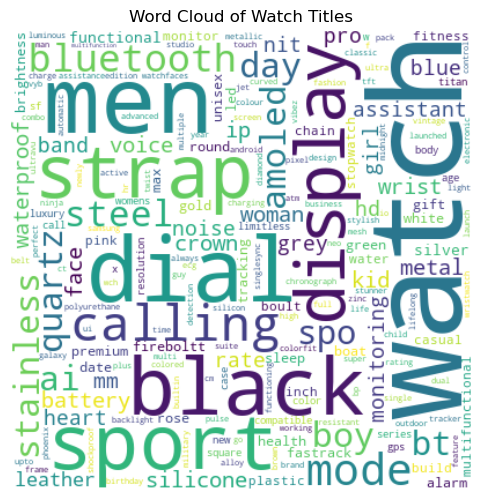

In [531]:
text = ' '.join(df['title'].astype(str).tolist())
wordcloud = WordCloud(width=400, height=400, background_color='white', collocations=False).generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Watch Titles')
plt.show()

# Unsupervised Learning

In [539]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=300)
X_tfidf = vectorizer.fit_transform(df['title'].astype(str))
X_dense = X_tfidf.toarray()

In [541]:
# num_features = df[['reviews']]
# scaler = StandardScaler()
# num_scaled = scaler.fit_transform(num_features)
# X = np.hstack((X_dense, num_scaled))

In [543]:
# PCA
pca = PCA(n_components= 0.98, random_state=42)
X_pca = pca.fit_transform(X_dense)

In [545]:
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_pca)


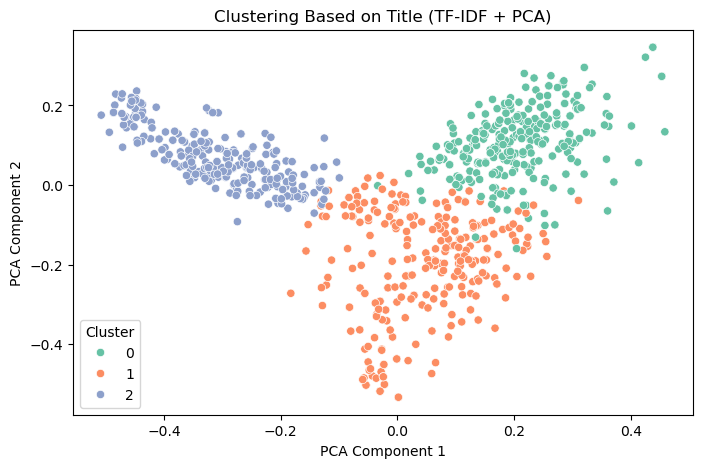

In [556]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='Set2')
plt.title("Clustering Based on Title (TF-IDF + PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

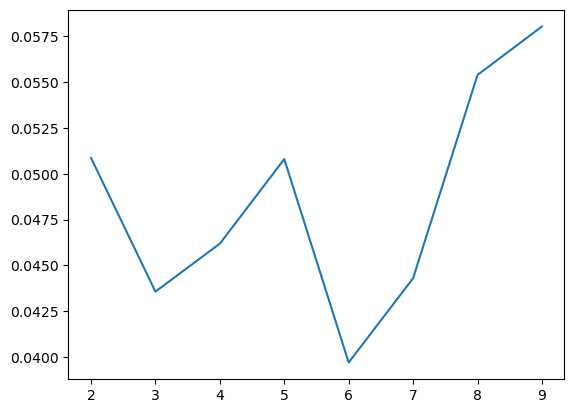

In [596]:
kr = range(2,10)
silhouette=[]
for k in kr:
    km = KMeans(n_clusters=k,random_state=100)
    km.fit_predict(X_pca)
    silhouette.append(silhouette_score(X_pca,km.labels_))

plt.plot(kr,silhouette)

In [598]:
def show_common_words(cluster_num, top_n=10):
    titles = df[df['Cluster'] == cluster_num]['title'].str.lower()
    all_words = ' '.join(titles).split()
    common = Counter(all_words).most_common(top_n)
    print(f"\nClusters:{cluster_num}:", common)

for i in range(3):
    show_common_words(i)


Clusters:0: [('dial', 310), ('watch', 251), ('men', 179), ('strap', 166), ('black', 139), ('quartz', 85), ('grey', 49), ('leather', 46), ('blue', 42), ('steel', 35)]

Clusters:1: [('watch', 426), ('men', 208), ('boy', 100), ('sport', 93), ('wrist', 79), ('kid', 77), ('waterproof', 72), ('black', 69), ('strap', 68), ('dial', 64)]

Clusters:2: [('watch', 263), ('calling', 226), ('display', 193), ('sport', 179), ('mode', 171), ('bluetooth', 128), ('ai', 111), ('black', 108), ('amoled', 107), ('bt', 98)]


In [600]:
label_map = {
    0: 'Digital',
    1: 'Analog',
    2: 'Smart'
}

df['Watch_type'] = df['Cluster'].map(label_map)

In [602]:
df.head()

,title,price,rating,reviews,Cluster,Watch_type
0,fireboltt ninja call pro plus watch inch bluet...,999.0,3.9,96054.0,2,Smart
1,fireboltt phoenix watch bluetooth calling spor...,1099.0,3.9,82577.0,2,Smart
2,noise twist round dial watch bluetooth calling...,1099.0,4.0,15003.0,2,Smart
4,noise pulse max display bluetooth calling watc...,1099.0,4.0,17941.0,2,Smart
5,boat lunar discovery w cm hd display turnbytur...,1199.0,3.9,23131.0,2,Smart


# Supervised Learning => Classification

In [565]:
Counter(df['Watch_type'])

Counter({'Digital': 325, 'Analog': 269, 'Smart': 267})

In [567]:
#X_com = np.hstack((X_pca, df[['price']].values))
le = LabelEncoder()
y = le.fit_transform(df['Watch_type'])

In [666]:
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [614]:
# sc = StandardScaler()
# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

### Logistic Regression

In [668]:
scores = cross_val_score(estimator=LogisticRegression(),X=X_com,y=y,scoring='accuracy',cv=5,verbose=2)
print("scores:", scores)
print("Mean accuracy:", scores.mean())

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
scores: [0.79190751 0.95930233 0.87790698 0.93023256 0.96511628]
Mean accuracy: 0.9048931307971502


In [670]:
cls = LogisticRegression(penalty='l2')
cls.fit(x_train,y_train)
y_pred = cls.predict(x_test)
acc1 = accuracy_score(y_pred,y_test)
print(f"Accuracy Score of Logistic Regression: {acc1:.2f}")

y_pred_train = cls.predict(x_train)
acc1t = accuracy_score(y_pred_train,y_train)
print(f"Accuracy Score of train data of Logistic Regression: {acc1t:.2f}")

Accuracy Score of Logistic Regression: 0.99
Accuracy Score of train data of Logistic Regression: 1.00


In [672]:
cm = confusion_matrix(y_pred,y_test)
print(cm)

[[53  0  0]
 [ 1 65  0]
 [ 0  0 54]]


In [674]:
cr = classification_report(y_pred,y_test)
print(cr)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       1.00      0.98      0.99        66
           2       1.00      1.00      1.00        54

    accuracy                           0.99       173
   macro avg       0.99      0.99      0.99       173
weighted avg       0.99      0.99      0.99       173



### KNN

In [676]:
scores = cross_val_score(estimator=KNeighborsClassifier(n_neighbors=3,metric='euclidean'),X=X_pca,y=y,scoring='accuracy',cv=5,verbose=2)
print("scores:", scores)
print("Mean accuracy:", scores.mean())

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
scores: [0.79768786 0.93604651 0.88953488 0.94767442 0.96511628]
Mean accuracy: 0.9072119908589865


In [690]:
knnws = KNeighborsClassifier(n_neighbors=6,metric='euclidean')
knnws.fit(x_train,y_train)
y_pred = knnws.predict(x_test)
acckws = accuracy_score(y_pred,y_test)
print(f"Accuracy Score of KNN without sampling: {acckws:.2f}")

y_pred_train = knnws.predict(x_train)
acckwst = accuracy_score(y_pred_train,y_train)
print(f"Accuracy Score of Train data KNN without sampling: {acckwst:.2f}")

Accuracy Score of KNN without sampling: 0.98
Accuracy Score of Train data KNN without sampling: 0.96


In [686]:
def Elbow(K):
    test_error = []
    for i in K:
        clf = KNeighborsClassifier(n_neighbors=i,metric='euclidean')
        clf.fit(x_train,y_train)
        tmp = clf.predict(x_test)
        tmp = accuracy_score(tmp,y_test)
        error = 1 - tmp
        test_error.append(error)
    return test_error

k = range(2,10,2)
new_k = Elbow(k)

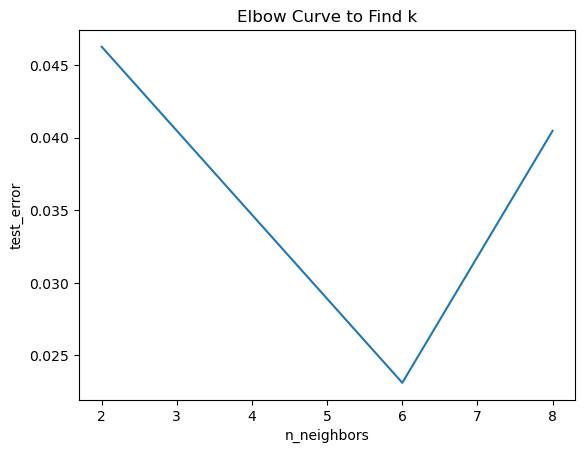

In [688]:
plt.plot(k,new_k)
plt.xlabel('n_neighbors')
plt.ylabel('test_error')
plt.title('Elbow Curve to Find k')
plt.show()

In [684]:
print(confusion_matrix(y_test, y_pred))

[[50  3  1]
 [ 0 65  0]
 [ 2  0 52]]


In [542]:
df.to_excel("watch_clean.xlsx", index=False)